# Computer Vision Project
## INSTANCE 22 Challenge

### Team
1. Shaurya Dewan - 2019101017
2. Ashwin Rao - 2019101049
3. Harshwardhan Prasad - 20

### Importing Required Libraries and Basic Setup

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import time
import tqdm

In [2]:
import wandb
wandb.init(project="test-project", entity="whatever")

wandb: Currently logged in as: srdewan (whatever). Use `wandb login --relogin` to force relogin


In [3]:
print_config()

MONAI version: 0.9.0rc1+19.g61a0dc35
Numpy version: 1.22.4
Pytorch version: 1.11.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 61a0dc35b8a5edf78487b30c02c7aa0e51fc3409
MONAI __file__: /home/srd/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.1.1
Tensorboard version: 2.9.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.2
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
os.environ["MONAI_DATA_DIRECTORY"] = "./results"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./results


## Dataloader Setup

### Setting Datafiles' Paths

In [5]:
data_dir = "./data/train"
train_images = sorted(
    glob.glob(os.path.join(data_dir, "data", "*.nii.gz")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "label", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [6]:
set_determinism(seed=0)

### Definition of Data Transforms

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=80,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 48),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 48),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=80,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

### Testing with Basic Dataloader

Dataloader Batch Dimensions =  torch.Size([8, 1, 96, 96, 48])
Original Scan Shape = torch.Size([96, 96, 48]), 
Segmented Scan Shape = torch.Size([96, 96, 48])
Unique Segmentation Mask Values =  [0. 1.]
Index = 2, Scan = 18


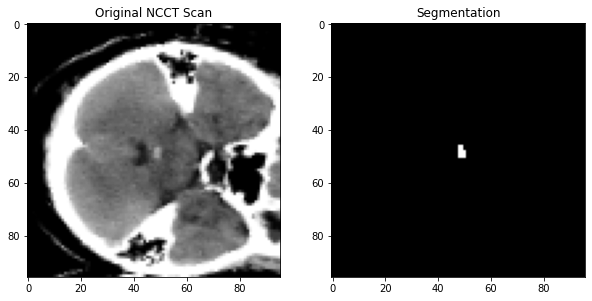

In [8]:
idx = 2
scan = 18

check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2)
check_data = first(check_loader)
image, label = (check_data["image"][idx][0], check_data["label"][idx][0])

print("Dataloader Batch Dimensions = ", check_data["image"].shape)
print(f"Original Scan Shape = {image.shape}, \nSegmented Scan Shape = {label.shape}")
print("Unique Segmentation Mask Values = ", np.unique(label[:, :, scan]))

print("Index = %d, Scan = %d" % (idx, scan))
plt.figure("Testing", (10, 10))
plt.subplot(1, 2, 1)
plt.title("Original NCCT Scan")
plt.imshow(image[:, :, scan], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmentation")
plt.imshow(label[:, :, scan], cmap="gray")
plt.show()

### Train and Validation Dataloaders

In [9]:
train_batch_size = 4
val_batch_size = 1

# train_ds = Dataset(data=train_files, transform=train_transforms)
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=train_batch_size, shuffle=True, num_workers=4)

# val_ds = Dataset(data=val_files, transform=val_transforms)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=val_batch_size, num_workers=4)

Loading dataset: 100%|████████████████████████████| 9/9 [00:02<00:00,  3.70it/s]


### UNet Architecture Definition

In [10]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Bottleneck
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

NameError: name 'Input' is not defined

### Defining Training Essentials

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_res_units = 2
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=num_res_units,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

### Defining Training Hyperparameters

In [12]:
max_epochs = 100
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

wandb.config = {
    "epochs": max_epochs,
    "batch_size": train_batch_size,
    "num_res_units": num_res_units
}

### Training Loop

In [ ]:
for epoch in tqdm.tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    start_time = time.time()
    
    for batch_data in tqdm.tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
#         print(
#             f"{step}/{len(train_ds) // train_loader.batch_size}, "
#             f"train_loss: {loss.item():.4f}")
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    end_time = time.time()
    print("epoch time = %f seconds" % (end_time - start_time))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
    
                roi_size = (96, 96, 48)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            wandb.log({"loss": epoch_loss, "validation": metric})
            wandb.watch(model)
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
                
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|                                                   | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.62s/it]

epoch 1 average loss: 0.6707
epoch time = 83.224861 seconds



  1%|▍                                        | 1/100 [01:30<2:28:51, 90.22s/it]

saved new best metric model
current epoch: 1 current mean dice: 0.0160
best mean dice: 0.0160 at epoch: 1
----------
epoch 2/100



100%|███████████████████████████████████████████| 23/23 [01:23<00:00,  3.61s/it]

epoch 2 average loss: 0.6486
epoch time = 83.017658 seconds



  2%|▊                                        | 2/100 [03:00<2:27:21, 90.22s/it]

saved new best metric model
current epoch: 2 current mean dice: 0.0187
best mean dice: 0.0187 at epoch: 2
----------
epoch 3/100



100%|███████████████████████████████████████████| 23/23 [01:25<00:00,  3.70s/it]

epoch 3 average loss: 0.6357
epoch time = 85.156334 seconds



  3%|█▏                                       | 3/100 [04:32<2:27:25, 91.19s/it]

saved new best metric model
current epoch: 3 current mean dice: 0.0219
best mean dice: 0.0219 at epoch: 3
----------
epoch 4/100



100%|███████████████████████████████████████████| 23/23 [01:24<00:00,  3.66s/it]

epoch 4 average loss: 0.6272
epoch time = 84.297750 seconds



  4%|█▋                                       | 4/100 [06:04<2:26:06, 91.31s/it]

saved new best metric model
current epoch: 4 current mean dice: 0.0238
best mean dice: 0.0238 at epoch: 4
----------
epoch 5/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.60s/it]

epoch 5 average loss: 0.6192
epoch time = 82.754485 seconds



  5%|██                                       | 5/100 [07:34<2:23:41, 90.75s/it]

saved new best metric model
current epoch: 5 current mean dice: 0.0261
best mean dice: 0.0261 at epoch: 5
----------
epoch 6/100



100%|███████████████████████████████████████████| 23/23 [01:24<00:00,  3.69s/it]

epoch 6 average loss: 0.6116
epoch time = 84.836042 seconds



  6%|██▍                                      | 6/100 [09:06<2:23:12, 91.41s/it]

saved new best metric model
current epoch: 6 current mean dice: 0.0282
best mean dice: 0.0282 at epoch: 6
----------
epoch 7/100



100%|███████████████████████████████████████████| 23/23 [01:22<00:00,  3.58s/it]

epoch 7 average loss: 0.6051
epoch time = 82.339058 seconds



  7%|██▊                                      | 7/100 [10:36<2:20:36, 90.72s/it]

saved new best metric model
current epoch: 7 current mean dice: 0.0309
best mean dice: 0.0309 at epoch: 7
----------
epoch 8/100



100%|███████████████████████████████████████████| 23/23 [01:20<00:00,  3.50s/it]

epoch 8 average loss: 0.5978
epoch time = 80.589862 seconds



  8%|███▎                                     | 8/100 [12:03<2:17:34, 89.72s/it]

saved new best metric model
current epoch: 8 current mean dice: 0.0367
best mean dice: 0.0367 at epoch: 8
----------
epoch 9/100



100%|███████████████████████████████████████████| 23/23 [01:19<00:00,  3.46s/it]

epoch 9 average loss: 0.5913
epoch time = 79.482815 seconds



  9%|███▋                                     | 9/100 [13:30<2:14:49, 88.90s/it]

saved new best metric model
current epoch: 9 current mean dice: 0.0428
best mean dice: 0.0428 at epoch: 9
----------
epoch 10/100



 91%|███████████████████████████████████████▎   | 21/23 [01:15<00:06,  3.30s/it]

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

### Plotting Losses

In [ ]:
plt.figure("train", (10, 10))

plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Epoch")
plt.ylabel("Epoch Average Loss")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Metric")
plt.plot(x, y)
plt.show()

### Visualizing Validation Outputs

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
scan = 24

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 48)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )

        plt.figure("Check", (20, 10))
        plt.subplot(1, 3, 1)
        plt.title(f"Image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, scan], cmap="gray")
        
        plt.subplot(1, 3, 2)
        plt.title(f"Label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, scan])
        
        plt.subplot(1, 3, 3)
        plt.title(f"Output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, scan])
        plt.show()
        
        if i == 5:
            break